In [1]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import netCDF4
import cftime
import seaborn
import cmocean
import matplotlib.gridspec
import scipy.interpolate

import glob
import pandas

import mpl_toolkits
import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

# 30day runs

import cam 400 data

In [2]:
cont_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm0400.ens_10members/ens_mean_cesm_files/'
cont_filename = 'B_1850_CAM5.30days.cam0400.clm0400.ens.cam.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
cont_cam_ds = xarray.open_dataset(cont_fileroot+cont_filename, decode_times=False)

In [3]:
topo_filename = 'USGS-gtopo30_1.9x2.5_remap_c050602.nc'
topo_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm0400.ens_10members/'
topo_ds = xarray.open_dataset(topo_fileroot+topo_filename, decode_times=False)

calculate latitude information

In [4]:
lat_lo_open = -35.
lat_hi_open = 35.
lat_lo = -10.
lat_hi = 10.
lon_lo = 270.
lon_hi = 330.

In [5]:
lat = cont_cam_ds['lat'].sel(lat=slice(lat_lo_open,lat_hi_open)).values
lon = cont_cam_ds['lon'].sel(lon=slice(lon_lo,lon_hi)).values

lat_indices = (lat>=lat_lo)&(lat<=lat_hi)
lat_indices_open = (lat>=lat_lo_open)&(lat<=lat_hi_open)
lon_indices = (lon>=lon_lo)&(lon<=lon_hi)

lat_subset = lat[lat_indices]
lon_subset = lon[lon_indices]

lat_subset_open = lat[lat_indices_open]

In [6]:
lat_subset_open = lat[lat_indices_open]

get land fraction info

In [7]:
LANDFRAC = cont_cam_ds['LANDFRAC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values[0,:,:]

get 400 fields for cam

In [8]:
PRECC_400_30d = cont_cam_ds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_400_30d = cont_cam_ds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values

import cam 1000 data

In [9]:
phys_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm1000.ens_10members/ens_mean_cesm_files/'
phys_filename = 'B_1850_CAM5.30days.cam0400.clm1000.ens.cam.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
phys_cam_ds = xarray.open_dataset(phys_fileroot+phys_filename, decode_times=False)

get 1000 fields for cam

In [10]:
PRECC_1000_30d = phys_cam_ds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_1000_30d = phys_cam_ds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values

convert time information

In [11]:
time_400 = cont_cam_ds['time']
time_converted = netCDF4.num2date(time_400.values, time_400.units, time_400.calendar)

time_manual = []
for t_idx in range(time_converted.size):
    year=time_converted[t_idx].year
    month=time_converted[t_idx].month
    day=time_converted[t_idx].day
    hour=time_converted[t_idx].hour
    minute=time_converted[t_idx].minute
    hour_round = round(hour+minute/60)
    time_manual.append(cftime.DatetimeNoLeap(year,month,day,hour_round))

specify timing

In [12]:
skip_time = 24
#end_time = 745

calculate PRECT diffs

In [13]:
PRECT_400_30d = PRECC_400_30d+PRECL_400_30d
PRECT_1000_30d = PRECC_1000_30d+PRECL_1000_30d

In [14]:
PRECT_1000_timemean_10day = numpy.mean(PRECT_1000_30d[skip_time:240,:,:], axis=0)
PRECT_1000_timemean_10day_landmask = numpy.copy(PRECT_1000_timemean_10day)
PRECT_1000_timemean_10day_landmask[LANDFRAC==0] = numpy.nan

PRECT_400_timemean_10day = numpy.nanmean(PRECT_400_30d[skip_time:240,:,:], axis=0)
PRECT_400_timemean_10day_landmask = numpy.copy(PRECT_400_timemean_10day)
PRECT_400_timemean_10day_landmask[LANDFRAC==0] = numpy.nan

In [15]:
PRECT_1000_timemean_30day = numpy.mean(PRECT_1000_30d[skip_time:,:,:], axis=0)
PRECT_1000_timemean_30day_landmask = numpy.copy(PRECT_1000_timemean_30day)
PRECT_1000_timemean_30day_landmask[LANDFRAC==0] = numpy.nan

PRECT_400_timemean_30day = numpy.nanmean(PRECT_400_30d[skip_time:,:,:], axis=0)
PRECT_400_timemean_30day_landmask = numpy.copy(PRECT_400_timemean_30day)
PRECT_400_timemean_30day_landmask[LANDFRAC==0] = numpy.nan

get topography info

In [16]:
topo_data = topo_ds['PHIS'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values/9.80665

In [17]:
lat

array([-33.15789474, -31.26315789, -29.36842105, -27.47368421,
       -25.57894737, -23.68421053, -21.78947368, -19.89473684,
       -18.        , -16.10526316, -14.21052632, -12.31578947,
       -10.42105263,  -8.52631579,  -6.63157895,  -4.73684211,
        -2.84210526,  -0.94736842,   0.94736842,   2.84210526,
         4.73684211,   6.63157895,   8.52631579,  10.42105263,
        12.31578947,  14.21052632,  16.10526316,  18.        ,
        19.89473684,  21.78947368,  23.68421053,  25.57894737,
        27.47368421,  29.36842105,  31.26315789,  33.15789474])

In [18]:
topo_data_landmask = numpy.copy(topo_data)
topo_data_landmask[LANDFRAC==0] = numpy.nan
topo_data_landmask_lat_subset = topo_data_landmask[(lat>=lat_lo)&(lat<=lat_hi),:]
topo_data_latmean = numpy.nanmean(topo_data_landmask_lat_subset, axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


# 10year simulations

400 clm runs

In [19]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm0400/'
cont_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc', decode_times=False)

In [20]:
PRECC_400_10y = cont_cam_mfds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_400_10y = cont_cam_mfds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECT_400_10y = PRECC_400_10y+PRECL_400_10y

1000 clm runs

In [21]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm1000/'
phys_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc')#, decode_times=False)

In [22]:
PRECC_1000_10y = phys_cam_mfds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_1000_10y = phys_cam_mfds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECT_1000_10y = PRECC_1000_10y+PRECL_1000_10y

take time averages

In [23]:
PRECT_400_timemean_10year = numpy.mean(PRECT_400_10y, axis=0)
PRECT_1000_timemean_10year = numpy.mean(PRECT_1000_10y, axis=0)

In [24]:
PRECT_400_timemean_10year_landmask = numpy.copy(PRECT_400_timemean_10year)
PRECT_1000_timemean_10year_landmask = numpy.copy(PRECT_1000_timemean_10year)

PRECT_400_timemean_10year_landmask[LANDFRAC==0] = numpy.nan
PRECT_1000_timemean_10year_landmask[LANDFRAC==0] = numpy.nan

# calculate all differences

In [25]:
PRECT_diffs_10day = PRECT_1000_timemean_10day_landmask-PRECT_400_timemean_10day_landmask
PRECT_diffs_30day = PRECT_1000_timemean_30day_landmask-PRECT_400_timemean_30day_landmask
PRECT_diffs_10year = PRECT_1000_timemean_10year_landmask-PRECT_400_timemean_10year_landmask

# wrf 50km runs

## 400 data

In [26]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [27]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [28]:
rainc_400 = cont_mfds['RAINC'].values
rainnc_400 = cont_mfds['RAINNC'].values

In [29]:
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [30]:
xlat_indices = (xlat>=-10)&(xlat<=10.)

In [31]:
hgt_50km = cont_mfds['HGT'].sel(Time=0).values

In [32]:
hgt_50km_landmask = numpy.copy(hgt_50km)
hgt_50km_landmask[landmask==0] = numpy.nan

hgt_50km_landmask_lat_subset = hgt_50km_landmask[xlat_indices[:,0],:]
hgt_50km_latmean = numpy.nanmean(hgt_50km_landmask_lat_subset, axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


## 1000 data

In [33]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [34]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [35]:
rainc_1000 = phys_mfds['RAINC'].values
rainnc_1000 = phys_mfds['RAINNC'].values

## calculate WRF differences

In [36]:
raintot_400 = rainc_400+rainnc_400
raintot_1000 = rainc_1000+rainnc_1000

raintot_400_diff = numpy.zeros((raintot_400.shape))*numpy.nan
raintot_400_diff[:-1,:,:] = numpy.diff(raintot_400, axis=0)#*(24./3) # convert to mm/day

raintot_1000_diff = numpy.zeros((raintot_1000.shape))*numpy.nan
raintot_1000_diff[:-1,:,:] = numpy.diff(raintot_1000, axis=0)#*(24./3) # convert to mm/day

# monthly mean
raintot_diffs_time_mean = numpy.nanmean(raintot_1000_diff[skip_time:,:,:] - raintot_400_diff[skip_time:,:,:], axis=0)
raintot_diffs_time_mean_landmask = numpy.copy(raintot_diffs_time_mean)
raintot_diffs_time_mean_landmask[landmask==0] = numpy.nan

raintot_400_time_mean = numpy.nanmean(raintot_400_diff[skip_time:,:,:], axis=0)
raintot_400_time_mean_landmask = numpy.copy(raintot_400_time_mean)
raintot_400_time_mean_landmask[landmask==0] = numpy.nan


In [37]:
day1_start_hour = 10 #6am = 10:00 because of the time offset
day1_end_hour = 24 #8pm = 24:00 because of time offset
raintot_diffs_time_mean_day1 = numpy.nanmean(raintot_1000_diff[day1_start_hour:day1_end_hour+1,:,:] - raintot_400_diff[day1_start_hour:day1_end_hour+1,:,:], axis=0)
raintot_diffs_time_mean_day1_landmask = numpy.copy(raintot_diffs_time_mean_day1)
raintot_diffs_time_mean_day1_landmask[landmask==0] = numpy.nan

# import WRF 2km days 2-10

In [38]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/400/001/'
cont_mfds_2km = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [39]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/1000/001/'
phys_mfds_2km = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [40]:
raintot_400_2km = cont_mfds_2km['RAINNC']
raintot_1000_2km = phys_mfds_2km['RAINNC']

In [41]:
raintot_400_2km_diffs = raintot_400_2km.diff(dim='Time').values
raintot_1000_2km_diffs = raintot_1000_2km.diff(dim='Time').values

In [42]:
raintot_400_2km_time_mean = numpy.nanmean(raintot_400_2km_diffs[skip_time:,:,:], axis=0)
raintot_1000_2km_time_mean = numpy.nanmean(raintot_1000_2km_diffs[skip_time:,:,:], axis=0)

raintot_diffs_2km_time_mean = raintot_1000_2km_time_mean-raintot_400_2km_time_mean

In [43]:
landmask_2km = cont_mfds_2km['LANDMASK'].values[0,:,:]

In [44]:
raintot_diffs_2km_time_mean_landmask = numpy.copy(raintot_diffs_2km_time_mean)
raintot_diffs_2km_time_mean_landmask[landmask_2km==0] = numpy.nan

In [45]:
landmask_2km.shape

(800, 2000)

In [46]:
xlat_2km = cont_mfds_2km['XLAT'].isel(Time=0).values[:,:]
xlong_2km = cont_mfds_2km['XLONG'].isel(Time=0).values[:,:]

In [47]:
hgt_2km = cont_mfds_2km['HGT'].sel(Time=0).values

In [48]:
hgt_2km_landmask = numpy.copy(hgt_2km)
hgt_2km_landmask[landmask_2km==0] = numpy.nan
hgt_2km_latmean = numpy.nanmean(hgt_2km_landmask, axis=0)

# import WRF 2km day 1

# create plots

# calculate lat means

In [49]:
raintot_diffs_2km_latmean = numpy.nanmean(raintot_diffs_2km_time_mean, axis=0)

In [50]:
raintot_diffs_time_mean_landmask.shape

(179, 289)

In [51]:
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_time_mean_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0)
raintot_diffs_latmean_day1 = numpy.nanmean(raintot_diffs_time_mean_day1_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0)
raintot_diffs_2km_latmean = numpy.nanmean(raintot_diffs_2km_time_mean, axis=0)
PRECT_diffs_10day_latmean = numpy.nanmean(PRECT_diffs_10day[lat_indices,:], axis=0)
PRECT_diffs_30day_latmean = numpy.nanmean(PRECT_diffs_30day[lat_indices,:], axis=0)
PRECT_diffs_10year_latmean = numpy.nanmean(PRECT_diffs_10year[lat_indices,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


calculate stdevs

In [52]:
raintot_diffs_latstd = numpy.nanstd(raintot_diffs_time_mean_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0, ddof=1)
raintot_diffs_day1_latstd = numpy.nanstd(raintot_diffs_time_mean_day1_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0, ddof=1)
raintot_diffs_2km_latstd = numpy.nanstd(raintot_diffs_2km_time_mean, axis=0, ddof=1)
PRECT_diffs_10day_latstd = numpy.nanstd(PRECT_diffs_10day[lat_indices,:], axis=0, ddof=1)
PRECT_diffs_30day_latstd = numpy.nanstd(PRECT_diffs_30day[lat_indices,:], axis=0, ddof=1)
PRECT_diffs_10year_latstd = numpy.nanstd(PRECT_diffs_10year[lat_indices,:], axis=0, ddof=1)



/export/home/blangenb/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


calculate stderr

In [53]:
raintot_diffs_latstderr = raintot_diffs_latstd/numpy.sqrt(xlat[:,0].size)
raintot_diffs_day1_latstderr = raintot_diffs_day1_latstd/numpy.sqrt(xlat[:,0].size)
raintot_diffs_2km_latstderr = raintot_diffs_2km_latstd/numpy.sqrt(xlat_2km[:,0].size)
PRECT_diffs_10day_latstderr = PRECT_diffs_10day_latstd/numpy.sqrt(lat_subset.size)
PRECT_diffs_30day_latstderr = PRECT_diffs_30day_latstd/numpy.sqrt(lat_subset.size)
PRECT_diffs_10year_latstderr = PRECT_diffs_10year_latstd/numpy.sqrt(lat_subset.size)



In [54]:
raintot_diffs_latmean_smooth = pandas.Series(raintot_diffs_latmean).rolling(window=3, center=True, min_periods=0).mean()
raintot_diffs_latmean_smooth_day1 = pandas.Series(raintot_diffs_latmean_day1).rolling(window=3, center=True, min_periods=0).mean()

raintot_diffs_2km_latmean_smooth = pandas.Series(raintot_diffs_2km_latmean).rolling(window=75, center=True, min_periods=0).mean()
PRECT_diffs_10day_latmean_smooth = pandas.Series(PRECT_diffs_10day_latmean).rolling(window=3, center=True, min_periods=0).mean()



In [55]:
raintot_diffs_latstd_smooth = pandas.Series(raintot_diffs_latstd).rolling(window=3, center=True, min_periods=0).std(ddof=1)
raintot_diffs_2km_latstd_smooth = pandas.Series(raintot_diffs_2km_latstd).rolling(window=75, center=True, min_periods=0).std(ddof=1)



## yes error bars

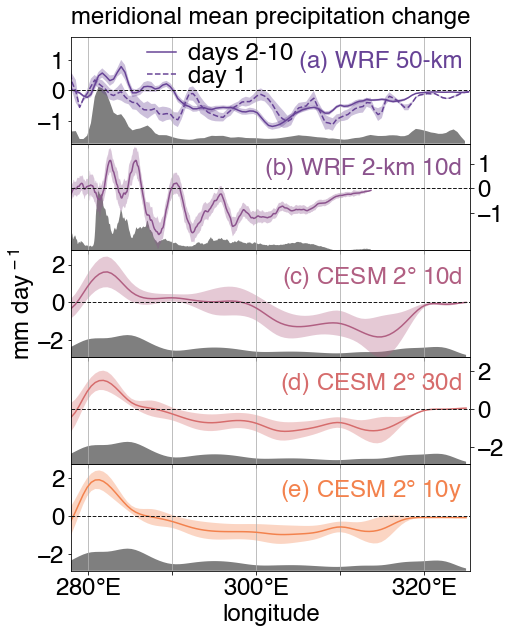

In [71]:
colors = [cmocean.cm.thermal(0.3),\
          cmocean.cm.thermal(0.4),\
          cmocean.cm.thermal(0.5),\
          cmocean.cm.thermal(0.6),\
          cmocean.cm.thermal(0.7)]

fontsize = 24

topo_color = '0.5'

fig = mp.figure(figsize=(6.5,8))

ymax = 3250.#1920.6472595214843
##################################################
ax1 = fig.add_subplot(511)
ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth*24., \
         color=colors[0],\
         label='days 2-10')

ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth_day1*24., \
         color=colors[0],\
         label='day 1', ls='--')

ax1topo = ax1.twinx()
ax1topo.fill_between(xlong[0,:]+360., \
                     numpy.zeros(hgt_50km_latmean.size), \
                     hgt_50km_latmean, \
                     facecolor='0', alpha=topo_color)
y0,y1 = ax1topo.get_ylim()
ax1topo.set_ylim(0,ymax)
ax1topo.axis('off')

ax1.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth-1.96*raintot_diffs_latstderr)*24.,\
                (raintot_diffs_latmean_smooth+1.96*raintot_diffs_latstderr)*24.,\
                facecolor=colors[0], alpha=0.333)


ax1.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth_day1-1.96*raintot_diffs_day1_latstderr)*24.,\
                (raintot_diffs_latmean_smooth_day1+1.96*raintot_diffs_day1_latstderr)*24.,\
                facecolor=colors[0], alpha=0.333)

##################################################
xvals = xlong_2km[0,:]+360.
yvals = raintot_diffs_2km_latmean_smooth*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
xvals_interp = numpy.linspace(xvals.min(), xvals.max(), 1000)
yvals_interp = f(xvals_interp)
ax2 = fig.add_subplot(512)
ax2.plot(xvals_interp,\
        yvals_interp, \
        color=colors[1],\
        label='WRF 2-km 10d')

ax2topo = ax2.twinx()
ax2topo.fill_between(xlong_2km[0,:]+360., \
                     numpy.zeros(hgt_2km_latmean.size), \
                     hgt_2km_latmean, \
                     facecolor='0', alpha=topo_color)
ax2topo.set_ylim(0,ymax)
ax2topo.axis('off')

yvals = raintot_diffs_2km_latstderr*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax2.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[1], alpha=0.333)

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10day_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax3 = fig.add_subplot(513)
ax3.plot(xvals_interp,\
        yvals_interp, \
        color=colors[2],\
        label='CESM 2$\degree$ 10d')

yvals = PRECT_diffs_10day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax3.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[2], alpha=0.333)

ax3topo = ax3.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax3topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=topo_color)
ax3topo.set_ylim(0,ymax)
ax3topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_30day_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax4 = fig.add_subplot(514)
ax4.plot(xvals_interp,\
        yvals_interp, \
        color=colors[3],\
        label='CESM 2$\degree$ 30d')

yvals = PRECT_diffs_30day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax4.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[3], alpha=0.333)

ax4topo = ax4.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax4topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=topo_color)
ax4topo.set_ylim(0,ymax)
ax4topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10year_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax5 = fig.add_subplot(515)
ax5.plot(xvals_interp,\
       yvals_interp, \
       color=colors[4],\
       label='CESM 2$\degree$ 10yr')

yvals = PRECT_diffs_30day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax5.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[4], alpha=0.333)

ax5topo = ax5.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax5topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=topo_color)
ax5topo.set_ylim(0,ymax)
ax5topo.axis('off')

##################################################

ax_list = [ax1,ax2,ax3,ax4,ax5]
label_list = ['(a) WRF 50-km',\
              '(b) WRF 2-km 10d', \
              '(c) CESM 2$\degree$ 10d', \
              '(d) CESM 2$\degree$ 30d', \
              '(e) CESM 2$\degree$ 10y']

fig.tight_layout()#h_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

map_lat_lo = -10.
map_lat_hi = 10.
map_lon_lo = 278
map_lon_hi = 325.5

ax1.zorder=1
ax2.zorder=1
ax3.zorder=1
ax4.zorder=1
ax5.zorder=1

ax1.set_facecolor('None')
ax2.set_facecolor('None')
ax3.set_facecolor('None')
ax4.set_facecolor('None')
ax5.set_facecolor('None')

[ax.tick_params(labelsize=fontsize) for ax in ax_list]
[ax.set_xticklabels(['','','']) for ax in ax_list]
[ax.axhline(0, lw=1, ls='--', c='0.1') for ax in ax_list]
#[ax.set_ylim(-1.8,1.8) for ax in ax_list]
[ax.set_yticks([-1.,0,1.]) for ax in ax_list[:2]]
[ax.set_yticks([-2.,0,2.]) for ax in ax_list[2:]]
[ax_list[i].yaxis.tick_right() for i in [1,3]]
[ax.set_xlim(map_lon_lo, map_lon_hi) for ax in ax_list]
#[ax.set_xlim(274.5, 325.5) for ax in ax_list]
#[ax.set_xlim(map_lon_lo, 322) for ax in ax_list]
[ax.xaxis.grid() for ax in ax_list]
[ax.set_xticks([280,290,300.,310,320.]) for ax in ax_list]

[ax_list[i].text(s=label_list[i], x=0.98, y=0.87,\
                 ha='right', va='top', \
                 fontsize=fontsize, \
                 color=colors[i], \
                 transform=ax_list[i].transAxes) for i in range(5)]

ax1pos = ax1.get_position()
ax4pos = ax4.get_position()
ax5pos = ax5.get_position()
fig.text(s='mm day$^{\,-1}$', \
         x=-0.01, y=ax5pos.y0+0.5*(ax1pos.y1-ax5pos.y0), \
         rotation=90, \
         transform=fig.transFigure, \
         va='center', \
         ha='right', \
         fontsize=fontsize)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(0.175,0.999), \
          bbox_transform=ax1.transAxes, loc='upper left', borderaxespad=0, ncol=1, labelspacing=0.01, \
          fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
          handletextpad=0.5, handlelength=1.2)

ax5.set_xlabel('longitude', fontsize=fontsize)
ax5.set_xticklabels(['280$\degree$E','','300$\degree$E','','320$\degree$E'])

ax1.set_ylim(-1.75,1.75)
ax2.set_ylim(-2.5,1.8)
ax3.set_ylim(-2.9,2.75)
ax4.set_ylim(-2.9,2.75)
ax5.set_ylim(-2.9,2.75)

ax1.text(s='meridional mean precipitation change', x=0.5, y=1.075, \
         ha='center', va='bottom', \
         transform=ax1.transAxes, fontsize=fontsize)
fig.savefig('../figures/POSTER_meridional_mean_changes.pdf', bbox_inches='tight', transparent=True)